# Experiments : Synthetic data, Spatial method

In this notebook, we run experiments by creating a synthetic delegation network using the spatial method. In this method, each users is represented by a position on a 2D plane and a users delegate in priority to users they are close on the plane.

In [1]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.utils import io
np.random.seed(42)

##  Save the results

We will use the following function to save the election, and the election results

In [2]:
def save_election(e, results, title=""):
    L = []
    C = []
    timestamp = int(time.time())
    for v in tqdm(e.list_voters):
        for i, d in enumerate(v.delegatees):
            L.append((v.id, d.id, i+1))
        if v.vote is not None:
            C.append((v.id, 1))
        else:
            C.append((v.id, 0))
        
    np.savetxt("Save/Synthetic/edges_%s_%i.csv"%(title,timestamp), L)
    np.savetxt("Save/Synthetic/nodes_%s_%i.csv"%(title,timestamp), C)
    results.to_csv("Save/Synthetic/results_%s_%i.csv"%(title, timestamp))

## Visualize the elections

What is particularly interesting with the space model is that we can visualize a delegation network on a 2D plane, using the following function:

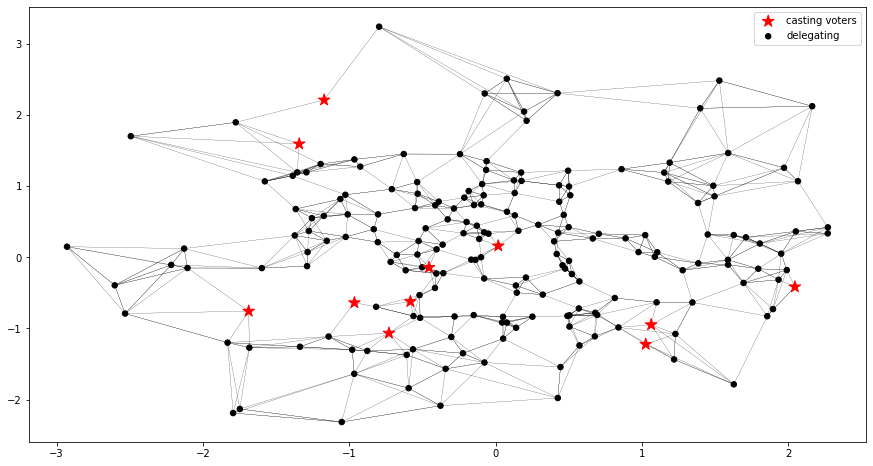

In [27]:
e, pos = rd.election_spatial(200, p_casting=0.05, n_delegatees=5, distrib_x="gauss",distrib_y="gauss")
dict_colors = rd.plot_network(pos, e, True)

Then, we can attribute the gurus with different delegation rules:

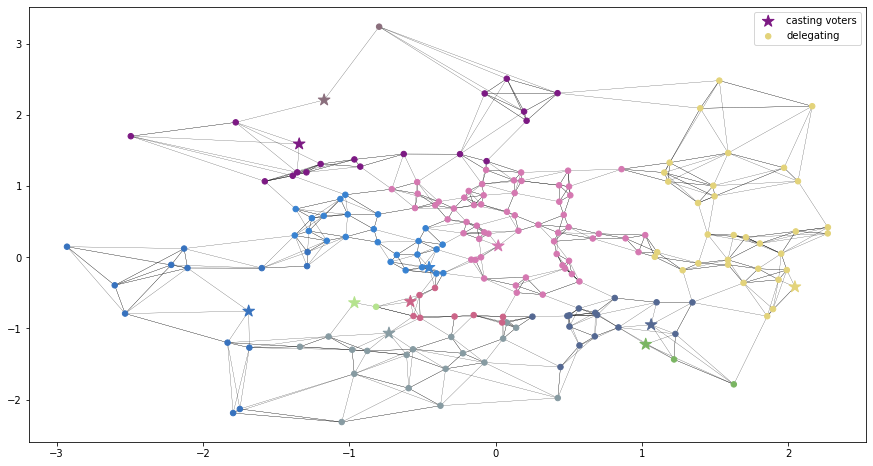

In [28]:
e.attribute_gurus(rd.rules.breadthFirst)
_ = rd.plot_network(pos, e, True, True, dict_colors)

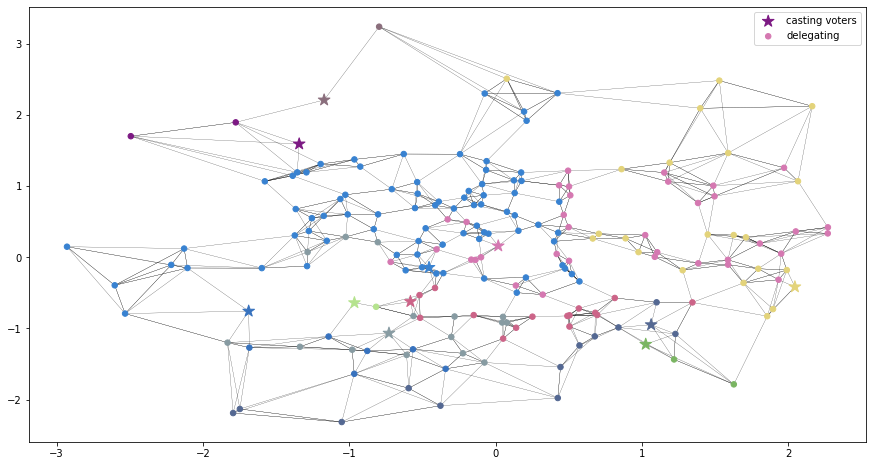

In [29]:
e.attribute_gurus(rd.rules.depthFirst)
_ = rd.plot_network(pos, e, True, True, dict_colors)

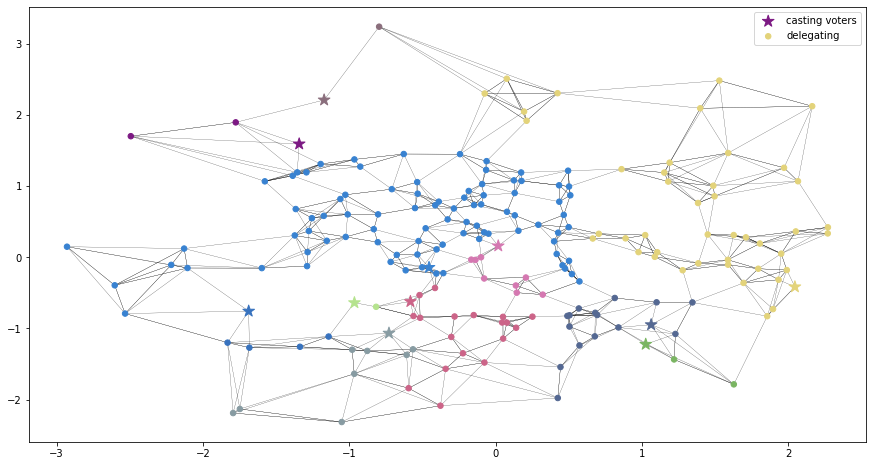

In [30]:
e.attribute_gurus(rd.rules.lexiMax)
_ = rd.plot_network(pos, e, True, True, dict_colors)

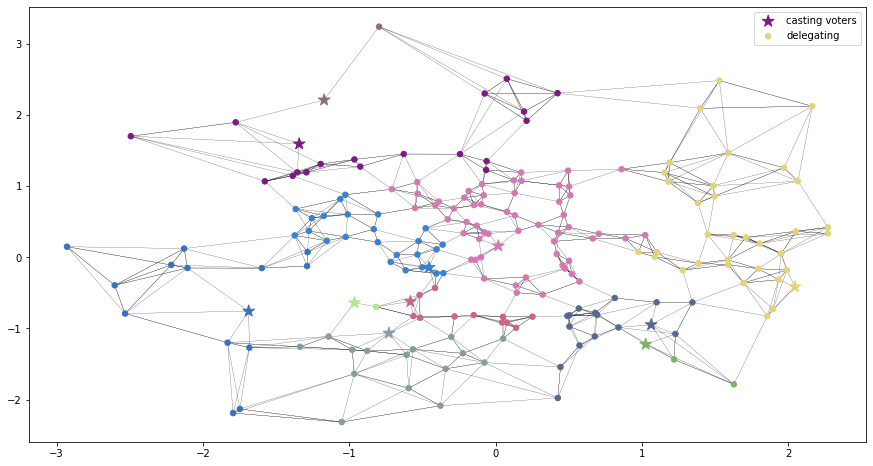

In [31]:
e.attribute_gurus(rd.rules.minSum)
_ = rd.plot_network(pos, e, True, True, dict_colors)

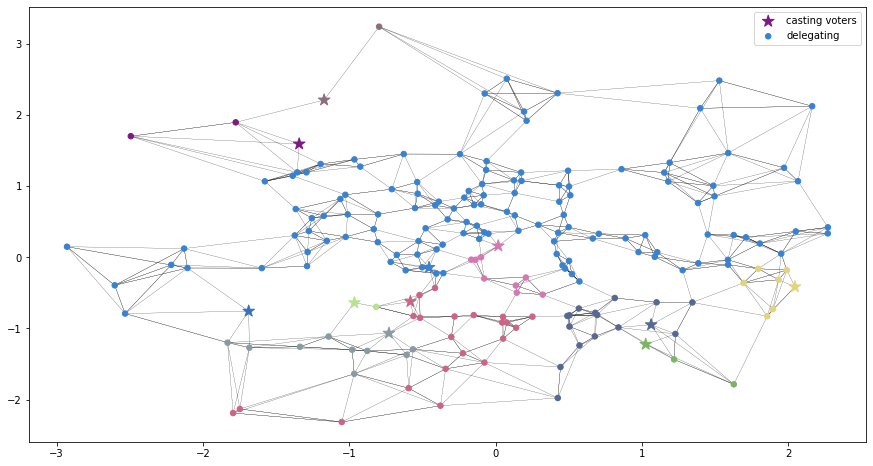

In [32]:
e.attribute_gurus(rd.rules.bordaArb)
_ = rd.plot_network(pos, e, True, True, dict_colors)

## Running the experiments

We will run the experiments on wide ruleset, testing all the rules described on the paper (BFD, DFD, MinSum, Diffusion, LexiMax and BordaArborescence). We will look at a wide set of metrics:

* Maximum rank in a delegation path
* Maximum length of a delegation path
* Average length of the delegation paths
* Maximum Weight/Representation of a casting voter
* Power entropy
* Maximum sum of rank of a delegation path
* Sum of all rank in the arborescence (for confluent rules)
* Average rank in the arborescence (for confluent rules)
* Unpopularity of the arborescence (for confluent rules)


In [33]:
rules = [rd.rules.breadthFirst, rd.rules.minSum, rd.rules.depthFirst, 
             rd.rules.diffusion, rd.rules.lexiMax, rd.rules.bordaArb]
rules_str = ["BFD", "MinSum", "DFD","Diffusion", "LexiMax","BordaArb"]
metrics_str = ["MaxRank", "MaxLength", "AvgLength","MaxWeight", "MaxRep",
                "PowerEntropy", "MaxSum", "SumRank", "AvgRank", "Unpopularity"]
n_rules = len(rules)

The following function run elections on networks and compute the results (using the metrics define above)

In [10]:
def run_election():
    tab_results = np.zeros((9, n_rules))
    n_iter = 100
    n_voter = 500
    n_rules = len(rules)

    for _ in tqdm(range(n_iter)):
        with io.capture_output() as captured:
            e,_ = rd.election_spatial(n_voter, n_delegatees=6)
            tab_results = np.zeros((10, n_rules))
            for i, rule in enumerate(rules):
                e.attribute_gurus(rule)
                tab_results[0, i] += e.max_rank
                tab_results[1, i] += e.max_length
                tab_results[2, i] += e.mean_length
                tab_results[3, i] += e.max_power
                tab_results[4, i] += e.max_representation
                tab_results[5, i] += e.power_entropy
                tab_results[6, i] += e.max_sum
                tab_results[7, i] += e.sum_rank
                tab_results[8, i] += e.avg_rank
                tab_results[9, i] += e.unpopularity                
            df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
            save_election(e, df, "space")


The following function simply create elections for different casting probability.

In [35]:
def create_elections(list_p = [0.5, 0.8, 0.9, 0.95, 0.99]):
    tab_results = np.zeros((9, n_rules))
    n_iter = 100
    n_voter = 500
    n_rules = len(rules)
    for proba_p in list_p:
        print(proba_p)
        for _ in tqdm(range(n_iter)):
            with io.capture_output() as captured:
                e,_ = rd.election_spatial(n_voter, p=proba_p, n_delegatees=6)
                tab_results = np.zeros((10, n_rules))
                df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
                save_election(e, df, "space-%.2f"%proba_p)
